# 0.  INSTALL MISSING DEPENDENCIES (RUN ONCE)

In [1]:
%pip install -q opencv-python tensorflow pandas scikit-learn pyyaml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1.  GLOBAL CONFIG  (EDIT HERE TO ADD NEW CLASSES)


In [2]:
import os, pathlib, yaml, json, cv2, random, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter

CONFIG = dict(
    data_root   = r"C:\Users\Shravan\Desktop\Indian sign Language-Real-life Words\New folder",          # six folders inside
    img_size    = 64,              # square input
    seq_length  = 1,               # 1 = single frame (can be >1 for sequences)
    val_split   = 0.15,
    test_split  = 0.15,
    seed        = 42,
    cnn_filters = [32,64,128],
    lstm_units  = 128,
    dropout     = 0.3,
    batch_size  = 32,
    epochs      = 30,
    lr          = 1e-3,
    patience    = 7,
    model_dir   = "runs"
)
# Auto-discover classes
CONFIG["class_names"] = sorted([d.name for d in pathlib.Path(CONFIG["data_root"]).iterdir() if d.is_dir()])
CONFIG["num_classes"] = len(CONFIG["class_names"])
print("Classes found:", CONFIG["class_names"])

Classes found: ['agree', 'bad', 'pain', 'small', 'today', 'you']


# 2.  PREPARE DATAFRAME (PATH + LABEL)

In [3]:
import pandas as pd
from collections import Counter

def build_file_df(data_root, exts=(".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")):
    paths, labels = [], []
    for cls in CONFIG["class_names"]:
        cls_path = pathlib.Path(data_root) / cls
        if not cls_path.is_dir():
            print(f"⚠️  folder not found: {cls_path}")
            continue
        found = False
        # ****  walk through any sub-folders (User_1, User_2, …)  ****
        for ext in exts:
            for fp in cls_path.rglob(f"*{ext}"):
                paths.append(str(fp))
                labels.append(cls)
                found = True
        if not found:
            print(f"⚠️  no images found in: {cls_path} (or its sub-folders)")
    if not paths:
        raise RuntimeError("No images found at all – check data_root and folder names.")
    df = pd.DataFrame({"path": paths, "label": labels})
    return df.sample(frac=1, random_state=CONFIG["seed"]).reset_index(drop=True)

df_all = build_file_df(CONFIG["data_root"])
print("Total images:", len(df_all))
print(df_all.label.value_counts())

Total images: 10800
label
agree    1800
you      1800
bad      1800
today    1800
pain     1800
small    1800
Name: count, dtype: int64


# 3.  TRAIN / VAL / TEST SPLIT

In [4]:
train_df, test_df = train_test_split(
    df_all, test_size=CONFIG["test_split"], stratify=df_all.label, random_state=CONFIG["seed"])
train_df, val_df  = train_test_split(
    train_df, test_size=CONFIG["val_split"]/(1-CONFIG["test_split"]),
    stratify=train_df.label, random_state=CONFIG["seed"])
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 7560 Val: 1620 Test: 1620


# 4.  TENSORFLOW DATA PIPELINE

In [5]:
cls2idx = {n: i for i, n in enumerate(CONFIG["class_names"])}

def decode_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (CONFIG["img_size"], CONFIG["img_size"]))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)          # <-- add sequence dimension (1, H, W, 3)
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

def df_to_ds(df, training=False):
    paths = df.path.values
    labels = np.array([cls2idx[lbl] for lbl in df.label])
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1000)
    ds = ds.batch(CONFIG["batch_size"]).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = df_to_ds(train_df, training=True)
val_ds   = df_to_ds(val_df)
test_ds  = df_to_ds(test_df)

# 5.  CNN + Bi-LSTM + DEEP STACKED Bi-GRU  (full replacement)

In [6]:
def build_hybrid_both_model():
    seq_len  = CONFIG["seq_length"]
    img_size = CONFIG["img_size"]
    dr       = CONFIG["dropout"]

    inputs = tf.keras.Input(shape=(seq_len, img_size, img_size, 3), name='frames')

    # --- CNN encoder (unchanged) ---
    cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(CONFIG["cnn_filters"][0], 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Dropout(dr),

        tf.keras.layers.Conv2D(CONFIG["cnn_filters"][1], 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Dropout(dr),

        tf.keras.layers.Conv2D(CONFIG["cnn_filters"][2], 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Dropout(dr),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dr)
    ], name='cnn_encoder')

    x = tf.keras.layers.TimeDistributed(cnn)(inputs)          # (batch, seq, 256)

    # 1. Bi-LSTM first
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(CONFIG["lstm_units"], return_sequences=True), merge_mode='concat')(x)
    x = tf.keras.layers.Dropout(dr)(x)

    # 2. Deep stacked Bi-GRU (2 layers, keep time)
    for i in range(2):
        x = tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(128, return_sequences=True), merge_mode='concat')(x)
        x = tf.keras.layers.Dropout(dr)(x)

    # 3. Final Bi-GRU that collapses time
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(128, return_sequences=False), merge_mode='concat')(x)
    x = tf.keras.layers.Dropout(dr)(x)

    # classifier
    out = tf.keras.layers.Dense(CONFIG["num_classes"], activation='softmax', name='pred')(x)

    model = tf.keras.Model(inputs, out, name='ISL_CNN_BiLSTM_BiGRU')
    return model

# build & compile
tf.keras.utils.set_random_seed(CONFIG["seed"])
model = build_hybrid_both_model()
model.compile(optimizer=tf.keras.optimizers.Adam(CONFIG["lr"]),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "ISL_CNN_BiLSTM_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ frames (InputLayer)             │ (None, 1, 64, 64, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 256)         │       127,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 256)         │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,412,294 (5.39 MB)

 Trainable params: 1,411,846 (5.39 MB)

 Non-trainable params: 448 (1.75 KB)

# 6.  TRAINING WITH EARLY-STOPPING

In [29]:
os.makedirs(CONFIG["model_dir"], exist_ok=True)   # make sure folder exists

cbs = [
    tf.keras.callbacks.EarlyStopping(patience=CONFIG["patience"], restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(CONFIG["model_dir"], "best_weights.weights.h5"),
        save_best_only=True,
        save_weights_only=True)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=CONFIG["epochs"],
                    callbacks=cbs)

Epoch 1/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - accuracy: 0.6739 - loss: 0.7957 - val_accuracy: 0.1667 - val_loss: 7.5528
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9070 - loss: 0.2591 - val_accuracy: 0.4352 - val_loss: 4.1273
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.9476 - loss: 0.1478 - val_accuracy: 0.9469 - val_loss: 0.1825
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.9712 - loss: 0.0903 - val_accuracy: 0.5346 - val_loss: 3.1104
Epoch 5/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.9690 - loss: 0.0887 - val_accuracy: 0.9623 - val_loss: 0.1039
Epoch 6/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - accuracy: 0.9806 - loss: 0.0573 - val_accuracy: 0.9457 - val_loss: 0.1729
Epoch 7/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.9831 - loss: 0.0563 - val_accuracy: 0.9858 - val_loss: 0.0373
Epoch 8/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.9796 - loss: 0

# 7.  EVALUATE ON TEST SET + CONFUSION MATRIX

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
=== Test-set Classification Report ===
              precision    recall  f1-score   support

       agree     1.0000    1.0000    1.0000       270
         bad     1.0000    1.0000    1.0000       270
        pain     1.0000    1.0000    1.0000       270
       small     1.0000    1.0000    1.0000       270
       today     1.0000    1.0000    1.0000       270
         you     1.0000    1.0000    1.0000       270

    accuracy                         1.0000      1620
   macro avg     1.0000    1.0000    1.0000      1620
weighted avg     1.0000    1.0000    1.0000      1620



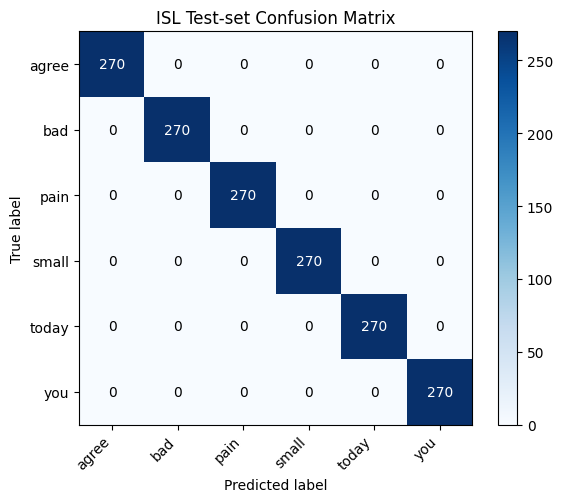

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# ----- true labels -----
y_true = np.concatenate([y for _, y in test_ds], axis=0)

# ----- predictions -----
y_pred = np.argmax(model.predict(test_ds), axis=1)

# ----- classification report -----
print("=== Test-set Classification Report ===")
print(classification_report(y_true, y_pred,
                          target_names=CONFIG["class_names"],
                          digits=4))

# ----- confusion matrix -----
cm = confusion_matrix(y_true, y_pred)

# ----- plot with pure matplotlib -----
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# colour bar
ax.figure.colorbar(im, ax=ax)

# ticks & labels
ax.set_xticks(np.arange(len(CONFIG["class_names"])))
ax.set_yticks(np.arange(len(CONFIG["class_names"])))
ax.set_xticklabels(CONFIG["class_names"], rotation=45, ha="right")
ax.set_yticklabels(CONFIG["class_names"])
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_title("ISL Test-set Confusion Matrix")

# text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# 8.  REAL-TIME WEBCAM DEMO

In [10]:
import cv2
import os

# ---- restore weights first ----
weights_path = os.path.join(CONFIG["model_dir"], "best_weights.weights.h5")
if os.path.exists(weights_path):
    model.load_weights(weights_path)
    print("✅ Weights restored from", weights_path)
else:
    print("⚠️  Saved weights not found – please run training once!")

# ---- demo functions ----
def preprocess_frame(frame):
    """Resize + normalize to match training."""
    img = cv2.resize(frame, (CONFIG["img_size"], CONFIG["img_size"]))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, 0)      # (1, H, W, 3)
    img = np.expand_dims(img, 0)      # (1, 1, H, W, 3)  seq_len=1
    return img

def realtime_demo():
    cap = cv2.VideoCapture(0)
    print("Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        blob = preprocess_frame(frame)
        pred = model.predict(blob, verbose=0)[0]
        cls  = CONFIG["class_names"][np.argmax(pred)]
        confidence = np.max(pred)

        cv2.putText(frame, f"{cls}  ({confidence:.2f})",
                    (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
        cv2.imshow("ISL Recognizer", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# ---- start webcam ----
realtime_demo()

c:\Users\Shravan\Desktop\AI-PROJECT1\tf-gpu\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Weights restored from runs\best_weights.weights.h5
Press 'q' to quit.
